# Implementing Pretrained U-Net for semantic segmentation on Oxford-IIIT Pet Dataset - Deep Learning for Artificial Intelligence (CCE PROFICIENCE JAN 2023)

---

**Student Name:**  Himanshu Pant, Koelgeet Kaur, Pratheeksha Nayak, Stan Iyer, Sanjeev, Sai Manikanta Mukka

**User ID:**    hpant438, Saimanikantamukka, koelgeetkaur45, stan.iyer, pratheeksha.pn95, sanjeev1110

**Email ID:**    hpant438@gmail.com, koelgeetkaur45@gmail.com, Saimanikantamukka@gmail.com, stan.iyer@gmail.com, pratheeksha.pn95@gmail.com, sanjeev1110@gmail.com

**Date of submission:**    April, 2023

**Deadline of submission:** 15th April, 11:59 PM

---

## Description:
This notebook outlines semantic segmentation using transfer learning approach. MobileNetv3 with LRASPP segmentation head is used with pretrained weights for the encoder and trained on Oxford IIIT Pet dataset.

Reference:
https://github.com/MrD1360/Keras-implementation-of-MobileNetv3-with-L-RASSP

In [ ]:
import os
import pprint
import numpy as np
import matplotlib.pyplot as plt

from IPython import display
from IPython.display import clear_output
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, CSVLogger
from keras import backend as K

from keras.models import Model
from keras.layers import Layer, Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, Activation, Input, Add, UpSampling2D
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply, Softmax, AveragePooling2D,Softmax

from keras.metrics import MeanIoU

In [ ]:
SEED = 42

# Set random seed for NumPy
np.random.seed(SEED)
# Set random seed for TensorFlow
tf.random.set_seed(SEED)

In [ ]:
# keras.backend.set_image_data_format('channels_last')

In [ ]:
# # Download the data
# oxford_iiit_pet_dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
(train_raw, val_raw, test_raw), ds_info = tfds.load(
                                          name='oxford_iiit_pet',
                                          split=['train+test[:40%]', 
                                                'test[40%:80%]', 
                                                'test[80%:]'],
                                          # shuffle_files=True,
                                          with_info=True
                                          )

In [ ]:
print(len(train_raw), len(val_raw), len(test_raw))

5148 1467 734


In [ ]:
# class Augment(tf.keras.layers.Layer):
#   def __init__(self, seed=42):
#     super().__init__()
#     # both use the same seed, so they'll make the same random changes.
#     self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
#     self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

#   def call(self, inputs, labels):
#     inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
#     labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
#     return inputs, labels

In [ ]:
# using nearest neighbor interpolation for resizing of images to 128 by 128
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
    return input_image, input_mask 

# Augmentation of images with random horizontal flip is done
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    return input_image, input_mask

# In addition, the image color values are normalized to the [0, 1] range. 
# Finally, as mentioned above the pixels in the segmentation mask are labeled either {1, 2, 3}. 
# For the sake of convenience, subtract 1 from the segmentation mask, resulting in labels that are : {0, 1, 2}.
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_image = (input_image - np.array([0.485, 0.456, 0.406], dtype=np.float32)) / np.array([0.229, 0.224, 0.225], dtype=np.float32)   # imagenet mean and std
    input_mask -= 1
    return input_image, input_mask


# There are two functions to preprocess the training and test datasets with a difference that between the two – we only perform image augmentation on the training dataset.
def load_dataset_train(datapoint):
  input_image = datapoint["image"]
  input_mask = datapoint["segmentation_mask"]
  input_image, input_mask = resize(input_image, input_mask)
  input_image, input_mask = augment(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

def load_dataset_test(datapoint):
  input_image = datapoint["image"]
  input_mask = datapoint["segmentation_mask"]
  input_image, input_mask = resize(input_image, input_mask)
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [ ]:
train_dataset = train_raw.map(load_dataset_train, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_raw.map(load_dataset_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_raw.map(load_dataset_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# configuration for splitting of dataset and nuber of epochs training will happen
BATCH_SIZE = 64
NUM_EPOCHS = 100
BUFFER_SIZE = 1000
VAL_SUBSPLITS = 5

TRAIN_LENGTH = len(train_dataset)
VAL_LENGTH = len(val_dataset)
TEST_LENGTH = len(test_dataset)

STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VALIDATION_STEPS = VAL_LENGTH // BATCH_SIZE // VAL_SUBSPLITS

In [ ]:
# use full train dataset
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# use validation dataset 
validation_batches = val_dataset.batch(BATCH_SIZE)

# use test dataset
test_batches = test_dataset.batch(BATCH_SIZE)

In [ ]:
# To display the list of images with their mask
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ["Input Image", "True Mask", "Predicted Mask"]
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

In [ ]:
# # Visualisation after preprocessing of train and test images, we can see the clear resizing in pixels

# # test image visualisation
# sample_batch = next(iter(test_batches))
# random_index = np.random.choice(sample_batch[0].shape[0])
# sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
# display([sample_image, sample_mask])

# # train image visualisation
# sample_batch = next(iter(train_batches))
# random_index = np.random.choice(sample_batch[0].shape[0])
# sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
# display([sample_image, sample_mask])

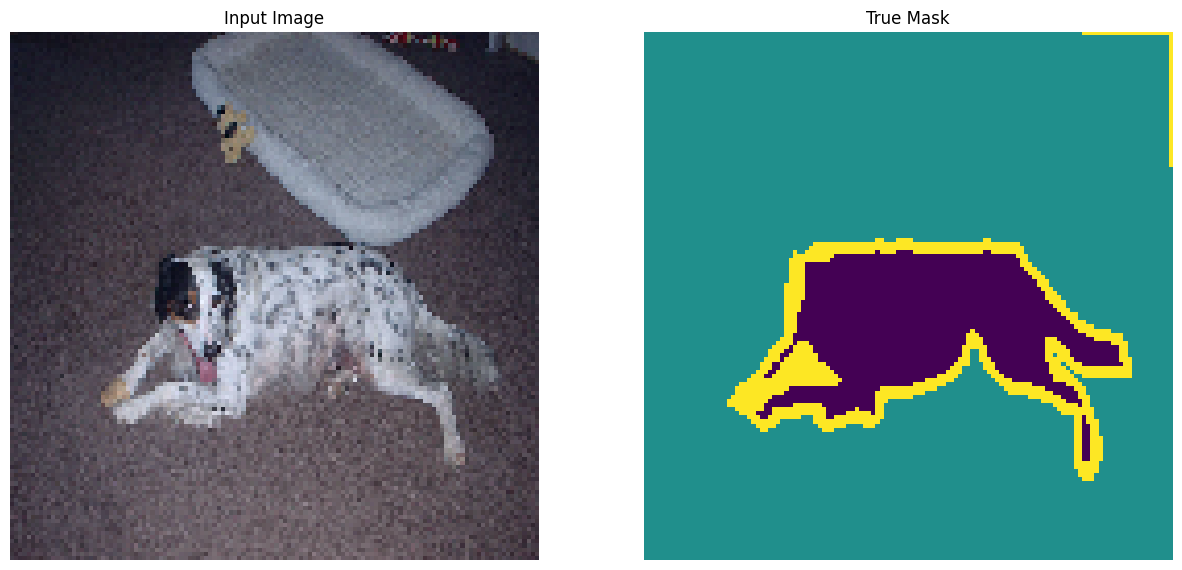

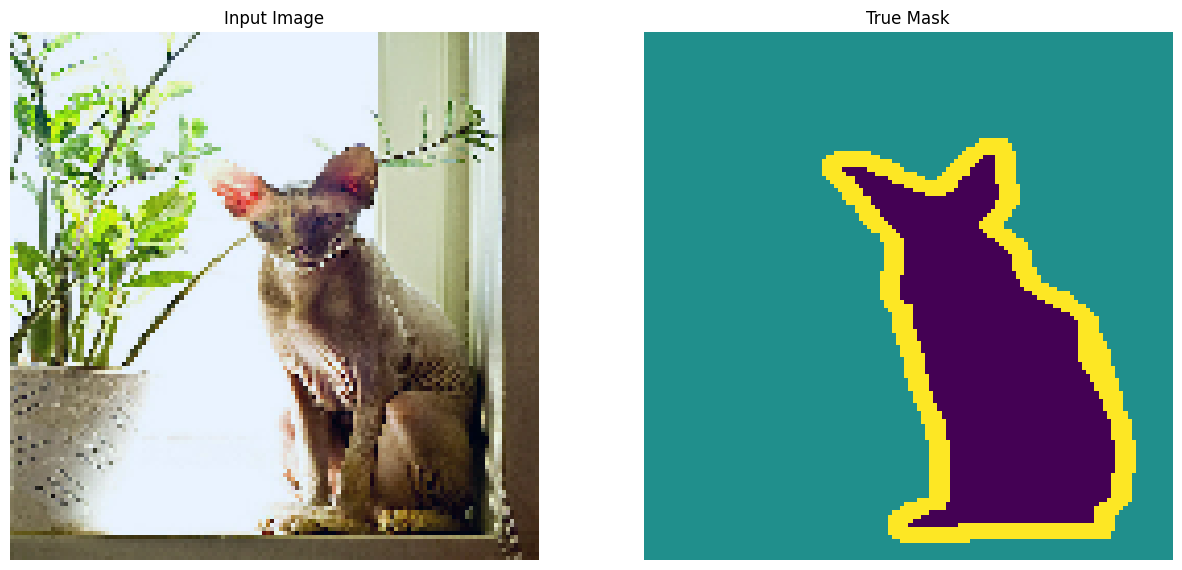

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

In [ ]:
pretrained_model = keras.applications.MobileNetV3Large(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
    )

pretrained_model.trainable = False

In [ ]:
#define hard swish activation function
def hard_swish(x):
    return x * tf.nn.relu6(x + 3) / 6


def convblock(x, kernel, exp_size, NL='RE', s=1):
    x = Conv2D(exp_size, (1, 1), strides=(s, s), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    if NL == 'RE':
        x = ReLU()(x)
    elif NL == 'HS':
        x = Activation(hard_swish)(x)
    return x

#squeeze and excitation block

def sq_n_ex(input_, r=4):

    '''
    param: input , ratio (r=4 in the paper)
    '''

    input_sNe_shape = (1, 1, input_.shape[-1])
    sNe_layer = GlobalAveragePooling2D()(input_)
    # sNe_layer = Reshape(input_sNe_shape)(sNe_layer)

    #ratio is used only in the first fully connected layer
    sNe_layer = Dense(input_.shape[-1]//r, activation='relu')(sNe_layer)  
    #hard sigmoid in the second FC
    sNe_layer = Dense(input_.shape[-1], activation='hard_sigmoid')(sNe_layer)
    
    return Multiply()([input_, sNe_layer])


def bottleneck(input_, kernel, exp_size, out_dim, SE=False, NL='RE', s=1):
    
    '''
    params: 
    - input: network input
    - kernel: kernel size
    - exp_size: expansion size
    - out_dim: layer output dimension
    - SE: booelan. If the "squeeze and excite" block is present
    - NL: Non linear function used. RE= relu or HS=hard swish
    - s: stride
    '''
    
    #first layer
    
    x = Conv2D(exp_size, (1, 1), strides=(1, 1), padding='same', use_bias=False)(input_)
    x = BatchNormalization()(x)
    if NL == 'RE':
        x = ReLU()(x)
    elif NL == 'HS':
        x = Activation(hard_swish)(x)
    
    #second layer
      
    x = DepthwiseConv2D(kernel_size=kernel, strides=(s,s), depth_multiplier=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
             
    if NL == 'RE':
        x = ReLU()(x)
    elif NL == 'HS':
        x = Activation(hard_swish)(x)
    
    #if squeeze and excite is in the block
    if SE:
        x = sq_n_ex(x)      

    # third layer

    x = Conv2D(out_dim, (1, 1), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    
    #residual just if stride=1 and same dimension of x and f(x) 
    if s == 1 and K.int_shape(input_)[-1] == out_dim:
        x = Add()([x,input_])
    
    return x

In [ ]:
pt_model_output = pretrained_model.get_layer('expanded_conv_11/Add').output
x = bottleneck(pt_model_output, (5, 5), 672, 160, True, 'HS', 1)
x = bottleneck(x, (5, 5), 960, 160, True, 'HS', 1)
x = bottleneck(x, (5, 5), 960, 160, True, 'HS', 1)
x = convblock(x, (1, 1), 960, 'HS', 1)
backbone_model = Model(inputs=pretrained_model.input, outputs=x)
# backbone_model.summary()

In [ ]:
def seg_head(base_model, n_class=3,  model_version= 'large'): 
    '''
    params:
    - base_model: mobileNetv3 already built
    - n_class: number of classes for segmentation 
    - model_version: define model version of the mobilenet dfor features extraciton
    '''

    if model_version=='large':
        # layer_name_1_8='re_lu_15'
        layer_name_1_8='expanded_conv_3/project/BatchNorm'
        layer_name_1_16='activation_6'
    
    # elif model_version=='small':
    #     layer_name_1_8='re_lu_7'
    #     layer_name_1_16='re_lu_22'
    
    # else:
    #     raise TypeError("Wrong model version inserted. Please insert large or small.") 
           
        
    #1/8 resolution output
    
    out_1_8= base_model.get_layer(layer_name_1_8).output
    
    #1/16 resolution output
    
    out_1_16= base_model.get_layer(layer_name_1_16).output
    
    # branch1
    x1 = Conv2D(128, (1, 1), use_bias=False)(out_1_16)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)  
    
    # branch2
    #!!! important: the pool size and the strides of the next layer must be resized in case of input dimension
    #               equal to the one in the paper (224,224,3)
    
    x2 = AveragePooling2D(pool_size=(4, 4), strides=(16, 20),data_format='channels_last')(out_1_16)
    x2 = Conv2D(128, (1, 1))(x2)
    x2 = Activation('sigmoid')(x2)
    # x2 = UpSampling2D(size=(int(x1.shape[1]), int(x1.shape[2])),data_format='channels_last',interpolation="bilinear")(x2)
       
    # branch3
    x3 = Conv2D(n_class, (1, 1))(out_1_8)
    
    # multiply
    m1 = Multiply()([x1, x2])
    m1 = UpSampling2D(size=(2, 2),data_format='channels_last',interpolation="bilinear")(m1)
    m1 = Conv2D(n_class, (1, 1))(m1)

    # add
    m2 = Add()([m1, x3])
    
    #adding UPsampling
    #!!! important: this upsampling is not part of the network presented in the paper
    #              but it's necessary for having output shape = input shape
    m2 = UpSampling2D(size=(8, 8),data_format='channels_last',interpolation="bilinear")(m2)

    # predictions 
    predictions =Softmax()(m2)  

    # final model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

In [ ]:
model = seg_head(backbone_model, model_version='large')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 64, 64, 16)   432         ['rescaling[0][0]']              
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 64, 64, 16)  64          ['Conv[0][0]']             

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy', MeanIoU(num_classes=3, sparse_y_pred=False)]
)

In [ ]:
# Define a function to return a commmonly used callback_list
def def_callbacks(filepath, mod_chk_mon = "val_loss", tensorboard = True, earlystop = 0):
    callback_list = []

    # Defualt callback
    callback_list.append(ModelCheckpoint(filepath,
                                         save_best_only=True,
                                         monitor=mod_chk_mon))
    if tensorboard:
      log_dir = "tensorLog_" + filepath
      callback_list.append(TensorBoard(log_dir=log_dir))

    if earlystop>0:
       callback_list.append(EarlyStopping(patience=earlystop))
    return callback_list

In [ ]:
model_history = model.fit(train_batches,
                          epochs=NUM_EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=validation_batches,
                          callbacks=def_callbacks(filepath="mnv3_lraspp.h5",
                                                  mod_chk_mon='val_loss', earlystop=10),
                          verbose=1,
                          )

Epoch 1/100
80/80 [==============================] - 50s 280ms/step - loss: 2.1936 - accuracy: 0.6807 - mean_io_u: 0.3816 - val_loss: 3.1632 - val_accuracy: 0.4509 - val_mean_io_u: 0.1701
Epoch 2/100
80/80 [==============================] - 8s 91ms/step - loss: 0.7551 - accuracy: 0.7618 - mean_io_u: 0.4966 - val_loss: 2.9826 - val_accuracy: 0.4586 - val_mean_io_u: 0.1715
Epoch 3/100
80/80 [==============================] - 7s 91ms/step - loss: 0.6448 - accuracy: 0.7846 - mean_io_u: 0.5258 - val_loss: 2.8025 - val_accuracy: 0.4723 - val_mean_io_u: 0.1751
Epoch 4/100
80/80 [==============================] - 7s 92ms/step - loss: 0.5706 - accuracy: 0.8025 - mean_io_u: 0.5500 - val_loss: 2.5944 - val_accuracy: 0.4954 - val_mean_io_u: 0.1824
Epoch 5/100
80/80 [==============================] - 7s 93ms/step - loss: 0.5213 - accuracy: 0.8147 - mean_io_u: 0.5678 - val_loss: 2.3163 - val_accuracy: 0.5443 - val_mean_io_u: 0.1991
Epoch 6/100
80/80 [==============================] - 10s 127ms/step 

In [ ]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    miou = history.history["mean_io_u"]
    val_miou = history.history["val_mean_io_u"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    # early stopping needs history length 
    epochs_range = range(len(history.history["val_loss"]))

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,3,1)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    plt.subplot(1,3,2)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,3,3)
    plt.plot(epochs_range, miou, label="train miou")
    plt.plot(epochs_range, val_miou, label="validataion miou")
    plt.title("Mean IoU")
    plt.xlabel("Epoch")
    plt.ylabel("Mean IoU")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

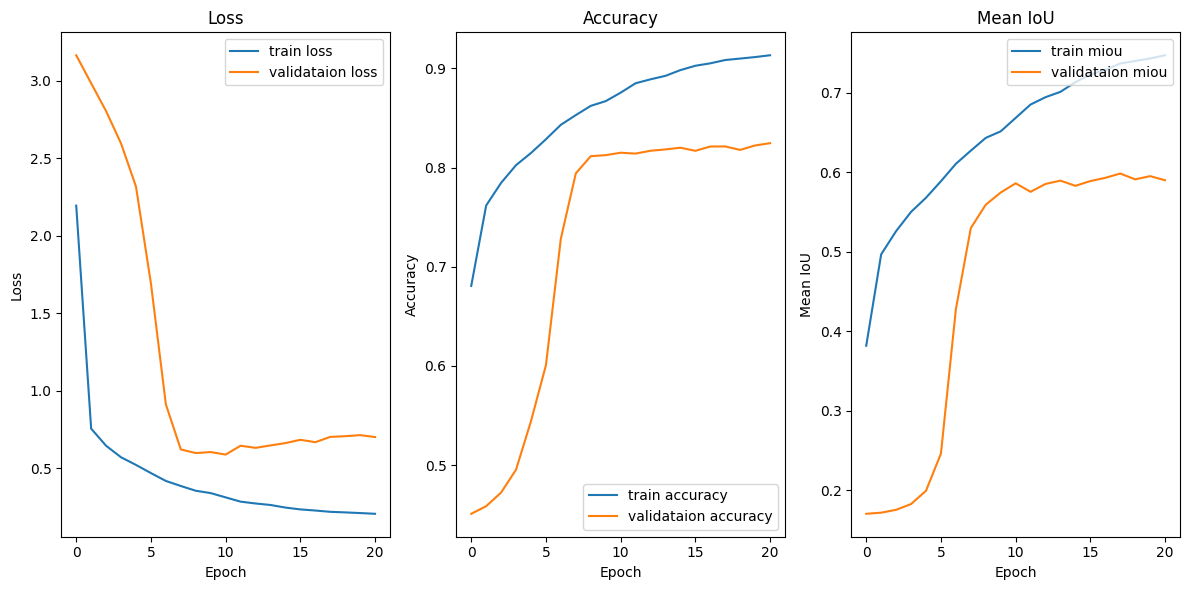

In [ ]:
# Display learning curves 
display_learning_curves(model.history)

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, model_name=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model_name.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model_name.predict(sample_image[tf.newaxis, ...]))])

count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 12


In [ ]:
show_predictions(test_batches.skip(1), model, 10)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# # Loading the best saved model via checkpoint to access the saved model
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
best_model = keras.models.load_model("mnv3_lraspp.h5", custom_objects={'hard_swish': hard_swish})

In [ ]:
best_model.evaluate(test_batches)

12/12 [==============================] - 6s 361ms/step - loss: 0.6197 - accuracy: 0.8117 - mean_io_u: 0.5826


[0.6196628212928772, 0.8117321729660034, 0.5826447606086731]

In [ ]:
model.evaluate(test_batches)

12/12 [==============================] - 3s 235ms/step - loss: 0.7707 - accuracy: 0.8193 - mean_io_u: 0.5841


[0.7707036137580872, 0.8192885518074036, 0.584101140499115]